## Final Prediction Using Regression

This is a notebook for final prediction.Prior to this notebook
1. Run 07featureextract notebook.  

Input :   
  
    a. April11cleaned.csv(The original csv with number of protest and other features)
    b. results/nepal_2018/cnnnighttrainvggcluster_feats.npy 
    c. results/nepl_2018/cnnnighttrainvggcluster_order.pkl (Get this output after running  07featureectract.ipynb)  
    
Output : Number of protest prediction    
    

In [1]:
#import necessary module
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [2]:
BASE_DIR = '..'

RANDOM_SEED = 7 # for reproducibility
COUNTRIES_DIR = os.path.join(BASE_DIR, 'preprocessing')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')

In [3]:
import sys
sys.path.append(BASE_DIR)
from utils import merge_on_lat_lon, assign_groups, run_randomized_cv, run_spatial_cv

In [4]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import xgboost as xgb
import seaborn as sns


In [5]:
df = pd.read_csv(os.path.join(COUNTRIES_DIR, 'Apr11cleaned.csv'))

In [6]:
df.shape

(89, 11)

In [7]:
df.head()

,cluster_lon,cluster_lat,electricityvalue,elevationvalue,pop15_49,pop0_5,mblphne,nightlights,agvalue,consumervalue,Noofprotest
0,85.36958,28.128750,0.918342,2541.4050,13.999999,2.000000,0.898354,0.0,0.951350,0.274684,3.0
1,85.30292,28.112083,0.969418,1878.7622,98.999990,16.999998,0.932959,0.0,0.870661,0.347699,26.0
2,84.61958,28.045416,0.978356,549.6891,67.000000,22.000000,0.978866,0.0,0.964586,0.574801,4.0
3,85.31958,28.012083,0.950552,2218.0757,31.000000,6.000000,0.915202,0.0,0.963398,0.284488,8.0
4,84.61958,28.003750,0.976045,1102.6179,49.999996,17.999998,0.970916,0.0,0.674828,0.659709,1379.0


In [8]:
df.corr()

,cluster_lon,cluster_lat,electricityvalue,elevationvalue,pop15_49,pop0_5,mblphne,nightlights,agvalue,consumervalue,Noofprotest
cluster_lon,1.000000,-0.178973,0.087289,0.199610,0.057812,0.048811,0.075979,0.061264,-0.070897,-0.114659,-0.043339
cluster_lat,-0.178973,1.000000,0.144543,0.731424,0.119378,0.101708,0.051127,0.091057,0.178635,0.206955,0.052296
electricityvalue,0.087289,0.144543,1.000000,0.134992,0.141114,0.146576,0.952155,0.154885,-0.132522,0.069862,0.066428
elevationvalue,0.199610,0.731424,0.134992,1.000000,0.110396,0.093781,0.039181,0.104807,0.139703,0.137938,0.012830
pop15_49,0.057812,0.119378,0.141114,0.110396,1.000000,0.995228,0.135806,0.838638,-0.566379,0.463398,0.348231
pop0_5,0.048811,0.101708,0.146576,0.093781,0.995228,1.000000,0.143916,0.855590,-0.593166,0.481202,0.346949
mblphne,0.075979,0.051127,0.952155,0.039181,0.135806,0.143916,1.000000,0.161541,-0.177838,0.082950,0.089015
nightlights,0.061264,0.091057,0.154885,0.104807,0.838638,0.855590,0.161541,1.000000,-0.768275,0.676316,0.447436
agvalue,-0.070897,0.178635,-0.132522,0.139703,-0.566379,-0.593166,-0.177838,-0.768275,1.000000,-0.725268,-0.302825
consumervalue,-0.114659,0.206955,0.069862,0.137938,0.463398,0.481202,0.082950,0.676316,-0.725268,1.000000,0.236460


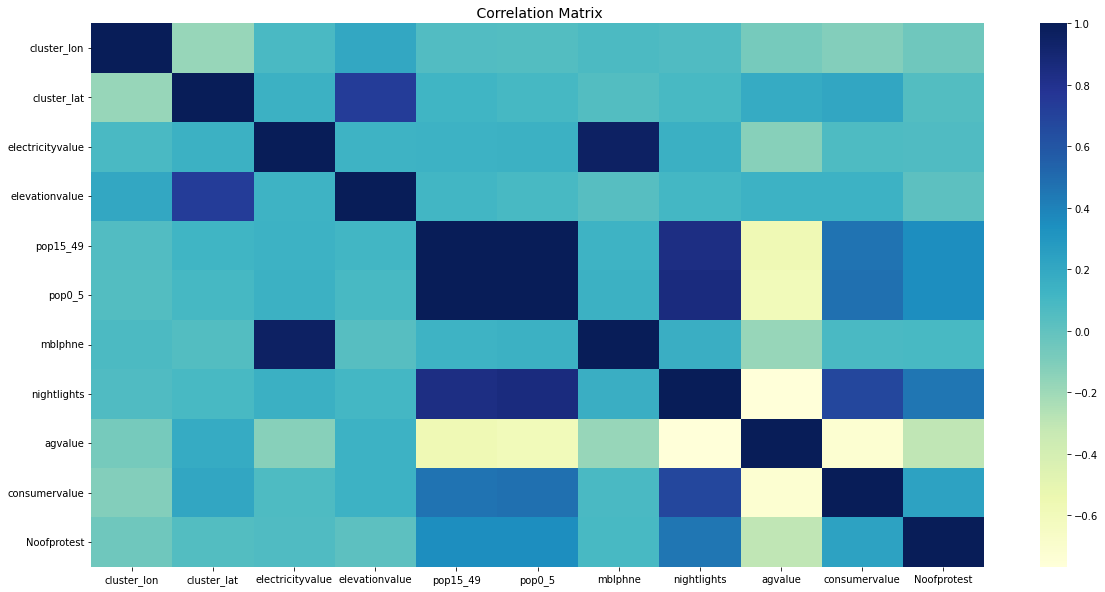

In [9]:
fig, ax = plt.subplots(figsize=(20,10))         
# Imbalanced DataFrame Correlation
corr = df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title(" Correlation Matrix", fontsize=14)
plt.show()

/home/samal/poudelnish/.conda/envs/aanisha/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='nightlights', ylabel='Density'>

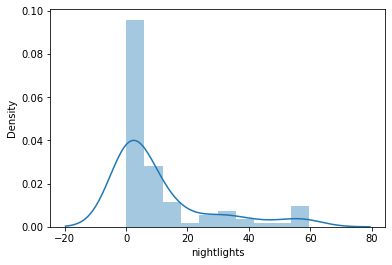

In [9]:
import seaborn as sns

sns.distplot(df["nightlights"])

In [10]:
df.columns,df.shape

(Index(['cluster_lon', 'cluster_lat', 'electricityvalue', 'elevationvalue',
        'pop15_49', 'pop0_5', 'mblphne', 'nightlights', 'agvalue',
        'consumervalue', 'Noofprotest'],
       dtype='object'),
 (89, 11))

In [11]:
#df.drop(columns={'image_name', 'image_lat', 'image_lon','agvalue', 'elevationvalue', 'mblphne', 'pop15_49',
#       'electricityvalue', 'pop0_5', 'nightlights','consumer_bin', 'is_train'},inplace=True)

In [12]:
df.describe()

,cluster_lon,cluster_lat,electricityvalue,elevationvalue,pop15_49,pop0_5,mblphne,nightlights,agvalue,consumervalue,Noofprotest
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,85.277261,27.584649,0.949801,1099.611175,1859.337122,253.662928,0.950683,10.784730,0.714348,0.643054,226.865169
std,0.263461,0.314472,0.107247,655.506163,4234.582861,536.755445,0.105679,16.131189,0.166856,0.221204,693.413480
min,84.619580,26.837084,0.000000,52.422500,13.999999,2.000000,0.000000,0.000000,0.411820,0.090941,1.000000
25%,85.152916,27.537083,0.946223,459.999820,88.000000,17.999998,0.949893,0.000000,0.603601,0.460698,12.000000
50%,85.319580,27.662083,0.968325,1318.371800,207.000000,34.000004,0.964112,5.292453,0.715111,0.671920,31.000000
75%,85.394585,27.762083,0.985674,1452.603300,1281.999900,196.000000,0.980196,13.407218,0.870661,0.843840,111.000000
max,85.836250,28.128750,1.000000,2541.405000,24019.000000,2978.000000,0.999553,59.707546,0.983011,0.955629,5789.000000


array([[<AxesSubplot:title={'center':'cluster_lon'}>,
        <AxesSubplot:title={'center':'cluster_lat'}>,
        <AxesSubplot:title={'center':'electricityvalue'}>],
       [<AxesSubplot:title={'center':'elevationvalue'}>,
        <AxesSubplot:title={'center':'pop15_49'}>,
        <AxesSubplot:title={'center':'pop0_5'}>],
       [<AxesSubplot:title={'center':'mblphne'}>,
        <AxesSubplot:title={'center':'nightlights'}>,
        <AxesSubplot:title={'center':'agvalue'}>],
       [<AxesSubplot:title={'center':'consumervalue'}>,
        <AxesSubplot:title={'center':'Noofprotest'}>, <AxesSubplot:>]],
      dtype=object)

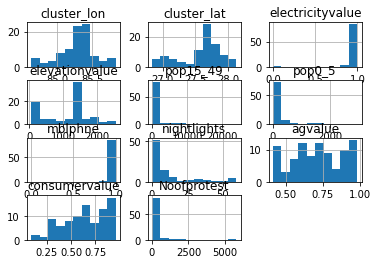

In [13]:
import seaborn as sns
df.hist()

# Predict Protest

In [10]:
def load_country(country):
    '''
    Organizes the country's dataframe so that each index corresponds to the index in the cluster features
    Returns the cluster features and the organized dataframe
    '''
   # country_processed_dir = os.path.join(COUNTRIES_DIR, 'processed')
    country_results_dir = os.path.join(RESULTS_DIR, country, 'cnn')
    x = np.load(os.path.join(country_results_dir, 'nighttrainvggcluster_feats.npy'))
    cluster_list = pickle.load(open(os.path.join(country_results_dir, 'nighttrainvggcluster_order.pkl'), 'rb'))
    cluster_list = pd.DataFrame.from_records(cluster_list, columns=['cluster_lat', 'cluster_lon'])
    cluster_list['feat_index'] = np.arange(len(cluster_list))
    
    df_clusters = pd.read_csv(os.path.join(COUNTRIES_DIR,'Apr11cleaned.csv'))
    #assert len(df_clusters) == len(cluster_list)

    df = merge_on_lat_lon(df_clusters, cluster_list, keys=['cluster_lat', 'cluster_lon'])
    assert len(df) == len(cluster_list)
   # assert len(df) == len(df_clusters) == len(cluster_list)
    df.sort_values('feat_index', ascending=True, inplace=True)
    return x, df

In [11]:
x_mw, df_mw = load_country('nepal_2018')

In [12]:
type(x_mw)

numpy.ndarray

In [13]:
df_mw['Noofprotest'] = df_mw['Noofprotest'].replace([0.00000],0.00002)

In [14]:
df_mw.head()

,cluster_lon,cluster_lat,electricityvalue,elevationvalue,pop15_49,pop0_5,mblphne,nightlights,agvalue,consumervalue,Noofprotest,feat_index
88,85.561250,26.837084,0.965833,52.422500,330.00000,93.000000,0.980307,6.092529,0.613839,0.649576,24.0,0
87,85.777916,26.853750,0.884982,97.133255,207.00000,38.000000,0.967104,0.000000,0.737086,0.132762,1.0,1
86,85.836250,26.903750,0.968001,124.652000,145.00002,28.000002,0.956075,5.357459,0.716957,0.291982,267.0,2
85,85.802920,26.937084,0.946466,138.007450,185.00002,34.000004,0.957765,4.400094,0.768728,0.403031,30.0,3
84,85.802920,26.953750,1.000000,144.857070,94.00000,18.000000,0.941019,2.100529,0.717316,0.376638,1.0,4


In [15]:
df_mw.columns

Index(['cluster_lon', 'cluster_lat', 'electricityvalue', 'elevationvalue',
       'pop15_49', 'pop0_5', 'mblphne', 'nightlights', 'agvalue',
       'consumervalue', 'Noofprotest', 'feat_index'],
      dtype='object')

In [16]:
x_mw.shape

(89, 4096)

In [17]:
x_mw.shape,df_mw.shape

((89, 4096), (89, 12))

In [18]:
df_mw.describe()

,cluster_lon,cluster_lat,electricityvalue,elevationvalue,pop15_49,pop0_5,mblphne,nightlights,agvalue,consumervalue,Noofprotest,feat_index
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,85.277261,27.584649,0.949801,1099.611175,1859.337122,253.662928,0.950683,10.784730,0.714348,0.643054,226.865169,44.000000
std,0.263461,0.314472,0.107247,655.506163,4234.582861,536.755445,0.105679,16.131189,0.166856,0.221204,693.413480,25.836021
min,84.619580,26.837084,0.000000,52.422500,13.999999,2.000000,0.000000,0.000000,0.411820,0.090941,1.000000,0.000000
25%,85.152916,27.537083,0.946223,459.999820,88.000000,17.999998,0.949893,0.000000,0.603601,0.460698,12.000000,22.000000
50%,85.319580,27.662083,0.968325,1318.371800,207.000000,34.000004,0.964112,5.292453,0.715111,0.671920,31.000000,44.000000
75%,85.394585,27.762083,0.985674,1452.603300,1281.999900,196.000000,0.980196,13.407218,0.870661,0.843840,111.000000,66.000000
max,85.836250,28.128750,1.000000,2541.405000,24019.000000,2978.000000,0.999553,59.707546,0.983011,0.955629,5789.000000,88.000000


In [19]:
y_mw = df_mw['Noofprotest'].values


In [20]:
type(y_mw)

numpy.ndarray

In [21]:
y_mw.shape

(89,)

/home/samal/poudelnish/.conda/envs/aanisha/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Noofprotest', ylabel='Density'>

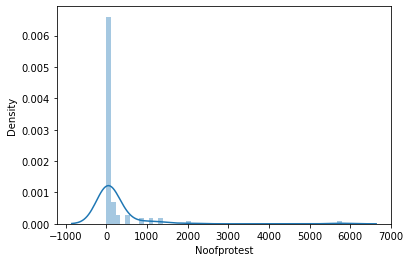

In [22]:
import seaborn as sns

sns.distplot(df_mw["Noofprotest"])



In [23]:
df_mw["Noofprotest"].mean()

226.86516853932585

In [24]:
# Calculate mae and rmse
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    
    return mae, rmse

In [27]:
# Naive baseline is the mean

import numpy as np


median_pred = np.mean(y_train)
print(median_pred)



median_preds = [median_pred for _ in range(len(y_test))]
true = y_test


# Display the naive baseline metrics
mb_mae, mb_rmse = evaluate_predictions(median_preds, true)
print('Mean Baseline  MAE: {:.4f}'.format(mb_mae))
print('Mean Baseline RMSE: {:.4f}'.format(mb_rmse))

233.30645161290323
Mean Baseline  MAE: 271.4665
Mean Baseline RMSE: 348.8058


In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_mw, y_mw, test_size=0.3, random_state=0)

In [32]:
#Linear Regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lin_regressor=LinearRegression()
mse=cross_val_score(lin_regressor,x_mw,y_mw,scoring='neg_mean_squared_error',cv=5)
mean_mse=np.mean(mse)
print(mean_mse)

-894030.1575027413


In [33]:
lin_regressor.fit(X_train,y_train)

LinearRegression()

In [34]:
pred_train_lr= lin_regressor.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lr)))
print(r2_score(y_train, pred_train_lr))

pred_test_lr= lin_regressor.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lr))) 
print(r2_score(y_test, pred_test_lr))

2.4534394157182623e-12
1.0
700.7384527046203
-3.0509487410183596


In [35]:
# Model Metrics
mae = np.mean(abs(pred_test_lr - y_test))
rmse = np.sqrt(np.mean((pred_test_lr - y_test) ** 2))
print("Linear Regression MAE:{:.4f}".format(mae))
print("Linear Regression RMSE:{:.4f}".format(rmse))


# Baseline Metrics
baseline = np.mean(y_train)
baseline_mae = np.mean(abs(baseline - y_test))
baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))


print("\nBaseline MAE: {:.4f}".format(baseline_mae))
print("Baseline RMSE:  {:.4f}".format(baseline_rmse))
     

Linear Regression MAE:592.0253
Linear Regression RMSE:700.7385

Baseline MAE: 271.4665
Baseline RMSE:  348.8058


In [29]:

#Ridge Regression


ridge=Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100,150,1000,10000]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(x_mw,y_mw)
# print(ridge_regressor.best_params_)
# print(ridge_regressor.best_score_)
# print(ridge_regressor.best_estimator_)

In [30]:
best_model = ridge_regressor.best_estimator_
best_model.fit(x_mw,y_mw)

Ridge(alpha=1000)

In [31]:
pred_train_lr= best_model.predict(X_train)
print(f'Root Mean squared Error for train  data  {np.sqrt(mean_squared_error(y_train,pred_train_lr))}')
print(f'R2 score {r2_score(y_train, pred_train_lr)}')

pred_test_lr= best_model.predict(X_test)
print(f'Root Mean squared Error for test data {np.sqrt(mean_squared_error(y_test,pred_test_lr))}') 
print(f'R2 score {r2_score(y_test, pred_test_lr)}')

Root Mean squared Error for train  data  647.4296328208029
R2 score 0.3341655954551447
Root Mean squared Error for test data 270.19958150145493
R2 score 0.39769815686463184


In [32]:
ridge_regressor.score(X_test,y_test)

-73007.81384356138

In [39]:
pred_train_ridge= best_model.predict(X_train)
print(f'Root Mean squared Error for train  data  {np.sqrt(mean_squared_error(y_train,pred_train_lr))}')
print(f'R2 score {r2_score(y_train, pred_train_lr)}')

pred_test_ridge= best_model.predict(X_test)
print(f'Root Mean squared Error for test data {np.sqrt(mean_squared_error(y_test,pred_test_lr))}') 
print(f'R2 score {r2_score(y_test, pred_test_lr)}')

Root Mean squared Error for train  data  647.4296328208029
R2 score 0.3341655954551447
Root Mean squared Error for test data 270.19958150145493
R2 score 0.39769815686463184


In [34]:
# Model Metrics
mae = np.mean(abs(pred_test_ridge - y_test))
rmse = np.sqrt(np.mean((pred_test_ridge - y_test) ** 2))


print("Ridge Regression MAE:{:.4f}".format(mae))
print("Ridge Regression RMSE:{:.4f}".format(rmse))


# Baseline Metrics
baseline = np.mean(y_train)
baseline_mae = np.mean(abs(baseline - y_test))
baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))


print("\nBaseline MAE: {:.4f}".format(baseline_mae))
print("Baseline RMSE:  {:.4f}".format(baseline_rmse))
     

Ridge Regression MAE:195.4946
Ridge Regression RMSE:270.1996

Baseline MAE: 271.4665
Baseline RMSE:  348.8058


In [85]:

lasso=Lasso()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100],'max_iter':[5000,10000,100000]}
lasso_regressor=GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=5)

lasso_regressor.fit(x_mw,y_mw)
# print(lasso_regressor.best_params_)
# print(lasso_regressor.best_score_)

In [91]:
best_model_lasso = lasso_regressor.best_estimator_
best_model_lasso.fit(x_mw,y_mw)

Lasso(alpha=50, max_iter=5000)

In [92]:
pred_train_lasso= best_model_lasso.predict(X_train)
print(f'Root Mean squared Error for train  data  {np.sqrt(mean_squared_error(y_train,pred_train_lasso))}')
print(f'R2 score {r2_score(y_train, pred_train_lasso)}')

pred_test_lasso= best_model_lasso.predict(X_test)
print(f'Root Mean squared Error for test data {np.sqrt(mean_squared_error(y_test,pred_test_lasso))}') 
print(f'R2 score {r2_score(y_test, pred_test_lasso)}')

Root Mean squared Error for train  data  704.6934438930483
R2 score 0.21117339860312678
Root Mean squared Error for test data 298.1361626842756
R2 score 0.26671270096333943


In [93]:
# Model Metrics
mae = np.mean(abs(pred_test_lasso - y_test))
rmse = np.sqrt(np.mean((pred_test_lasso - y_test) ** 2))

print("Lasso Regression MAE:{:.4f}".format(mae))
print("Lasso Regression RMSE:{:.4f}".format(rmse))


# Baseline Metrics
baseline = np.mean(y_train)
baseline_mae = np.mean(abs(baseline - y_test))
baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))


print("\nBaseline MAE: {:.4f}".format(baseline_mae))
print("Baseline RMSE:  {:.4f}".format(baseline_rmse))
     

Lasso Regression MAE:227.4368
Lasso Regression RMSE:298.1362

Baseline MAE: 271.4665
Baseline RMSE:  348.8058


In [94]:
prediction_lasso=lasso_regressor.predict(X_test)
prediction_ridge=ridge_regressor.predict(X_test)

In [95]:
predict_linear = lin_regressor.predict(X_test)

In [36]:

xg_reg= xgb.XGBRegressor(objective = 'reg:squarederror' , 
                         colsample_bytree=0.4,
                         gamma=0,                 
                         learning_rate=0.1,
                         max_depth=3,
                         min_child_weight=1.5,
                         n_estimators=5000,  
                         reg_alpha=0.01,
                         reg_lambda=0.01,
                         subsample=0.6,
                         #reg_alpha=1e-5,
                         #reg_lambda=0.45,
                         #subsample=0.95,
                         seed=42)



In [42]:
xg_reg.fit(X_train,y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.01, reg_lambda=0.01, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [43]:

pred_train_boost= xg_reg.predict(X_train)
print(f'Root Mean squared Error for train  data  {np.sqrt(mean_squared_error(y_train,pred_train_boost))}')
print(f'R2 score {r2_score(y_train, pred_train_boost)}')

pred_test_boost= xg_reg.predict(X_test)
print(f'Root Mean squared Error for test data {np.sqrt(mean_squared_error(y_test,pred_test_boost))}') 
print(f'R2 score {r2_score(y_test, pred_test_boost)}')

Root Mean squared Error for train  data  0.0023427011042276187
R2 score 0.9999999999912821
Root Mean squared Error for test data 313.6417809854901
R2 score 0.1884548797779757


In [44]:
# Model Metrics
mae = np.mean(abs(pred_test_boost - y_test))
rmse = np.sqrt(np.mean((pred_test_boost - y_test) ** 2))

print("XGBoost Regression MAE:{:.4f}".format(mae))
print("XGBoost Regression RMSE:{:.4f}".format(rmse))


# Baseline Metrics
baseline = np.median(y_train)
baseline_mae = np.mean(abs(baseline - y_test))
baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))


print("\nBaseline MAE: {:.4f}".format(baseline_mae))
print("Baseline RMSE:  {:.4f}".format(baseline_rmse))
     

XGBoost Regression MAE:243.4668
XGBoost Regression RMSE:313.6418

Baseline MAE: 198.9444
Baseline RMSE:  391.2842


In [45]:
r2_xgb = r2_score(y_test, pred_test_boost)

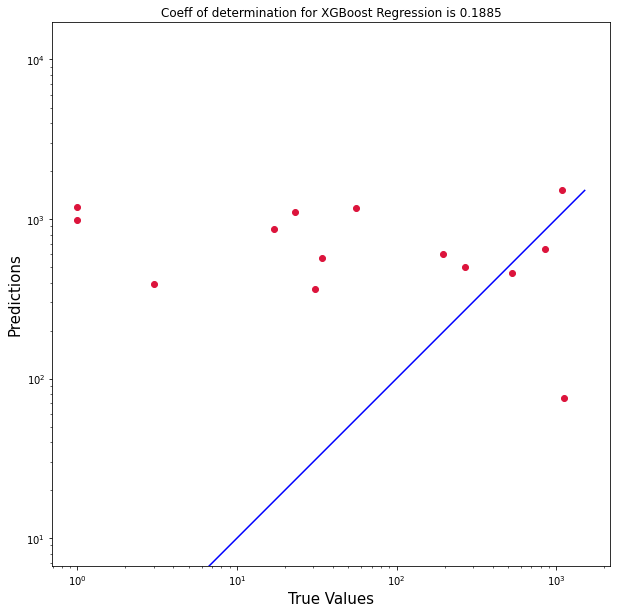

In [46]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, pred_test_lr, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(pred_test_lr), max(y_test))
p2 = min(min(pred_test_lr), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel(f'True Values' , fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title("Coeff of determination for XGBoost Regression is {:.4f}".format(r2_xgb))
plt.axis('equal')
plt.show()

/home/samal/poudelnish/.conda/envs/aanisha/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

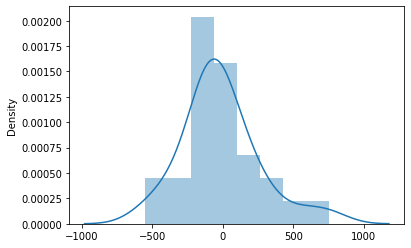

In [56]:
sns.distplot(y_test-pred_test_lr)

/home/samal/poudelnish/.conda/envs/aanisha/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

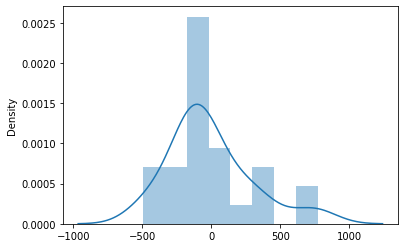

In [57]:

sns.distplot(y_test-prediction_lasso)

/home/samal/poudelnish/.conda/envs/aanisha/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

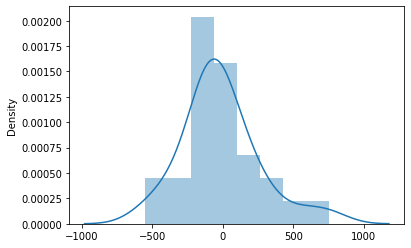

In [58]:
import seaborn as sns

sns.distplot(y_test-prediction_ridge)

/home/samal/poudelnish/.conda/envs/aanisha/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

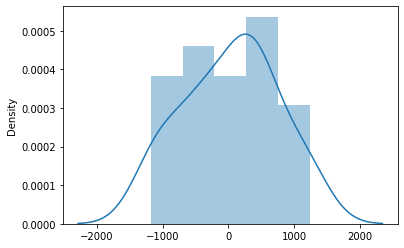

In [59]:
import seaborn as sns

sns.distplot(y_test-predict_linear)

/home/samal/poudelnish/.conda/envs/aanisha/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Noofprotest', ylabel='Density'>

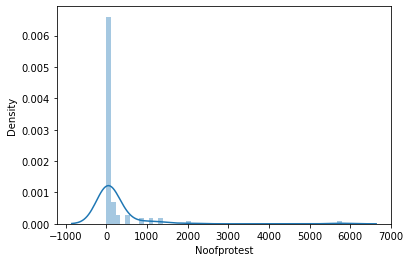

In [60]:
sns.distplot(df['Noofprotest'])

In [72]:
r2_ridge = r2_score(y_test, prediction_ridge)
print('r2 score for ridge  model is', r2_ridge)

r2 score for ridge  model is 0.39769815686463184


In [73]:
r2_lasso = r2_score(y_test, prediction_lasso)
print('r2 score for lass0  model is', r2_lasso)

r2 score for lass0  model is 0.26671270096333943


In [74]:
r2_linear = r2_score(y_test, predict_linear)
print('r2 score for linear  model is', r2_linear)

r2 score for linear  model is -3.0509487410183596


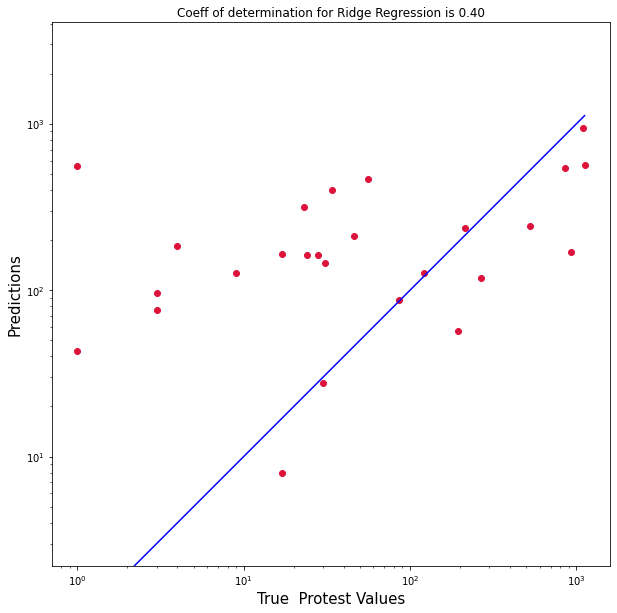

In [75]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, prediction_ridge, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(prediction_ridge), max(y_test))
p2 = min(min(prediction_ridge), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title("Coeff of determination for Ridge Regression is {:.2f}".format(r2_ridge))
plt.xlabel('True  Protest Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

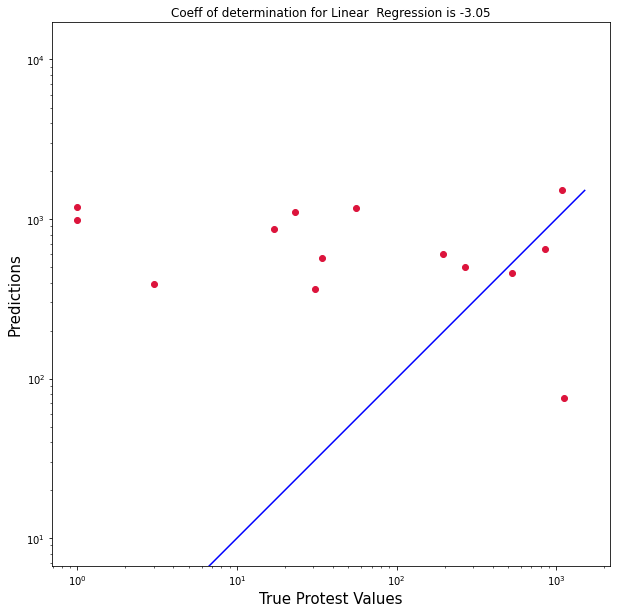

In [76]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, predict_linear, c='crimson')
plt.yscale('log')
plt.xscale('log')
plt.title("Coeff of determination for Linear  Regression is {:.2f}".format(r2_linear))
p1 = max(max(predict_linear), max(y_test))
p2 = min(min(predict_linear), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Protest Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

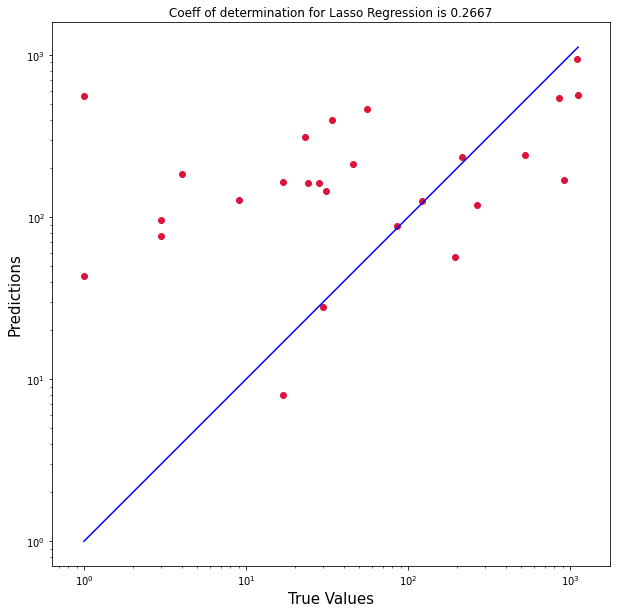

In [77]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, prediction_ridge, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(prediction_lasso), max(y_test))
p2 = min(min(prediction_lasso), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel(f'True Values' , fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title("Coeff of determination for Lasso Regression is {:.4f}".format(r2_lasso))
plt.axis('equal')
plt.show()

In [82]:
original_ytest =[]
x_max = 5000
x_min = 1
for i in list_ytest:
    original_p = i*(x_max-x_min) + x_min
    original_ytest.append(round(original_p,0))
print(original_ytest)       

NameError: name 'list_ytest' is not defined

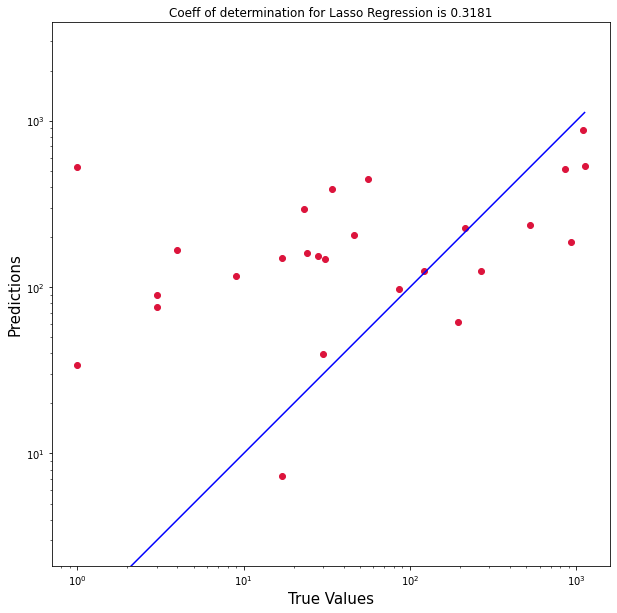

In [152]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, prediction_ridge, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(prediction_lasso), max(y_test))
p2 = min(min(prediction_lasso), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel(f'True Values' , fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title("Coeff of determination for Lasso Regression is {:.4f}".format(r2_lasso))
plt.axis('equal')
plt.show()

In [35]:
BASE_DIR1 = '/work/samal/poudelnish/1finaltry'

RANDOM_SEED = 7 # for reproducibility
COUNTRIES_DIR1 = os.path.join(BASE_DIR1, 'data')
RESULTS_DIR1 = os.path.join(BASE_DIR1, 'results')
FIGURES_DIR1 = os.path.join(BASE_DIR1, 'figures')

In [36]:
df1 = pd.read_csv(os.path.join(COUNTRIES_DIR1, 'processed','newclusters.csv'))

In [47]:
df1.describe()

,cluster_lat,cluster_lon,Noofprotest,consumervalue
count,22043.000000,22043.000000,22043.000000,22043.000000
mean,27.516025,85.268747,3.043869,0.425042
std,0.389632,0.355206,356.389750,0.152361
min,26.778750,84.594580,0.000000,0.000000
25%,27.170416,84.986250,0.000000,0.322350
50%,27.545416,85.269585,0.000000,0.410800
75%,27.845417,85.569580,0.000000,0.512350
max,28.237083,85.886250,52787.000000,1.000000


In [49]:
df1['Noofprotest'].where(df['Noofprotest'] > 5579, 5577, inplace=True)

In [52]:
df1['Noofprotest'].values[df1['Noofprotest'] > 5579] = 5577

In [53]:
#df1['Noofprotest'] = df1['Noofprotest'].apply(lambda x: [y if y <=5579 else 5577 for y in x])

In [54]:
df1.describe()

,cluster_lat,cluster_lon,Noofprotest,consumervalue
count,22043.000000,22043.000000,22043.000000,22043.000000
mean,27.516025,85.268747,23.166629,0.425042
std,0.389632,0.355206,354.479429,0.152361
min,26.778750,84.594580,0.000000,0.000000
25%,27.170416,84.986250,0.000000,0.322350
50%,27.545416,85.269585,0.000000,0.410800
75%,27.845417,85.569580,0.000000,0.512350
max,28.237083,85.886250,5577.000000,1.000000


In [55]:
df1.to_csv(os.path.join(COUNTRIES_DIR1, 'processed','clusters1.csv'),index=False)

In [56]:
def load_country1(country):
    '''
    Organizes the country's dataframe so that each index corresponds to the index in the cluster features
    Returns the cluster features and the organized dataframe
    '''
    country_processed_dir = os.path.join(COUNTRIES_DIR1, 'processed')
    country_results_dir = os.path.join(RESULTS_DIR1, country, 'cnn')
    x = np.load(os.path.join(country_results_dir, 'cluster_feats.npy'))
    cluster_list = pickle.load(open(os.path.join(country_results_dir, 'cluster_order.pkl'), 'rb'))
    cluster_list = pd.DataFrame.from_records(cluster_list, columns=['cluster_lat', 'cluster_lon'])
    cluster_list['feat_index'] = np.arange(len(cluster_list))
    
    df_clusters = pd.read_csv(os.path.join(country_processed_dir,'clusters1.csv'))
    #assert len(df_clusters) == len(cluster_list)

    df = merge_on_lat_lon(df_clusters, cluster_list, keys=['cluster_lat', 'cluster_lon'])
    assert len(df) == len(cluster_list)
   # assert len(df) == len(df_clusters) == len(cluster_list)
    df.sort_values('feat_index', ascending=True, inplace=True)
    return x, df

In [57]:
x_mw1, df_mw1 = load_country1('nepal_2018')

In [58]:
prediction_ridge=ridge_regressor.predict(x_mw1)

In [59]:
len(prediction_ridge)

4409

In [60]:
prediction_ridge

array([ 406.47620191,  239.46849865,  360.0590891 , ...,  132.46565237,
       -102.39212482, -249.94966978])

In [64]:
df_mw1.head()

,cluster_lat,cluster_lon,Noofprotest,consumervalue,feat_index
4394,26.77875,85.261250,0,0.4607,0
4395,26.77875,85.294586,0,0.4958,1
4396,26.77875,85.302920,0,0.5355,2
4397,26.77875,85.319580,0,0.2495,3
4398,26.77875,85.336250,0,0.1998,4


In [62]:
df_predicted = pd.DataFrame(prediction_ridge)

In [63]:
df_predicted.head()

,0
0,406.476202
1,239.468499
2,360.059089
3,455.691151
4,119.589638


In [66]:
df_final = pd.concat([df_mw1, df_predicted], axis=1)

In [67]:
df_final.columns

Index(['cluster_lat', 'cluster_lon', 'Noofprotest', 'consumervalue',
       'feat_index', 0],
      dtype='object')

In [69]:
df_final.rename(columns={"0": "predicted_protest"},inplace=True)

In [70]:
df_final.to_csv("predicted_protest.csv",index=False)